# Car Driving without Cameras 
## Poster Day Demonstration 


In [58]:
import os
import glob
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np
import pandas as pd
import cv2
from matplotlib.patches import Polygon
import re
from PIL import Image as Im

%matplotlib inline

# Context Detection 
## Image Semantic Histograms

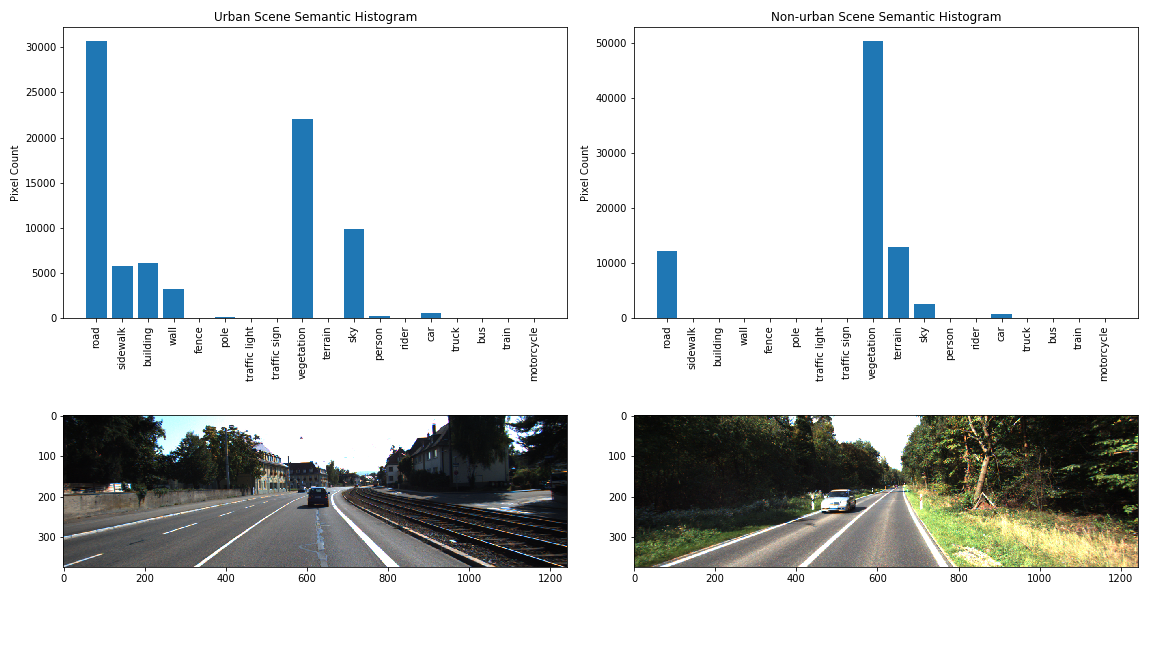

In [2]:
Image('semantic_hist.png')

## Pointclouds

In [3]:
path = "/mnt/storage/home/ja17618/scratch/DATA_DIR/training/"
f_lidar = glob.glob(os.path.join(path, 'velodyne', '*.bin'))
f_rgb = glob.glob(os.path.join(path, 'image_2', '*.png'))
f_labels = glob.glob(os.path.join(path, 'label_2', '*.txt'))
data_tag = [name.split('/')[-1].split('.')[-2] for name in f_lidar]
files=[tag+".bin" for tag in data_tag]

In [4]:
colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k',
    'DontCare' : 'k'
}
axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame_statistics(dataset_velo, dataset_rgb, dataset_label, points=1.0):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    dataset         : `raw` dataset.

    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
# #     dataset_gray = list(dataset.gray)
#     dataset_rgb =  dataset+".png"
#     dataset_velo = dataset+".bin"
    
#     print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data
    box_3d=[]
    cls=[]
    for line in dataset_label: 
        ret = line.split()
        cls.append(ret[0])
        h, w, l, x, y, z, r = [float(i) for i in ret[-7:]]
        box3d = np.array([h, w, l, x, y, z, r])
        box_3d.append(box3d)
    
    f, ax = plt.subplots(1, 1, figsize=(15, 5))

    ax.imshow(dataset_rgb)
    ax.set_title('Right RGB Image (cam3)')
#     plt.show()
    
    
        
    points_step = int(1. / points)
    point_size = 0.1 * (1. / points)
    velo_range = range(0, dataset_velo.shape[0], points_step)
    velo_frame = dataset_velo[velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.set_facecolor('xkcd:black')
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='jet')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
            
#         for t_rects, t_type in zip(box_3d, cls):
#             print(t_rects,t_type)
#             draw_box÷(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')    
    max_x = np.max(dataset_velo[:,0])
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,max_x),ylim3d=(-max_x/2,max_x/2))
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
        axes=[1, 2] # Y and Z axes
    )
    plt.show()

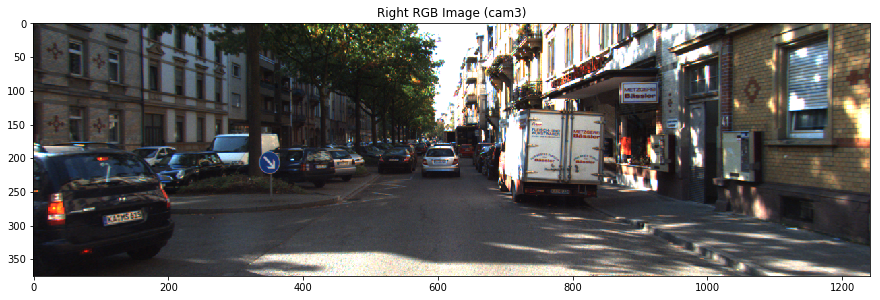

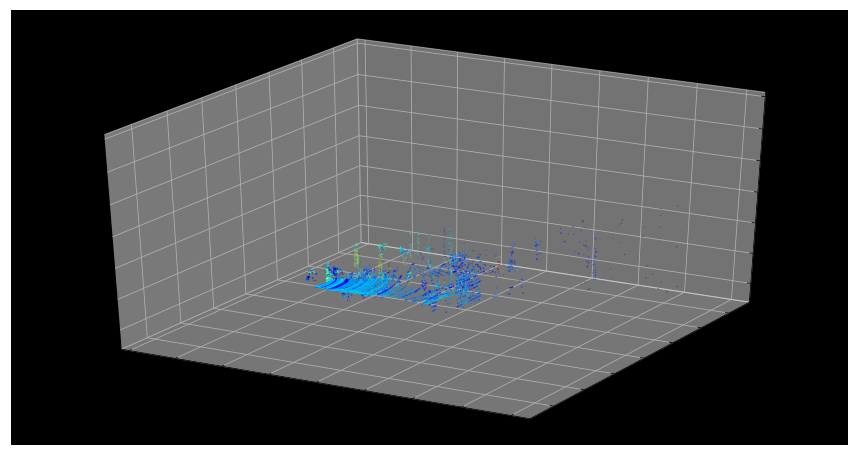

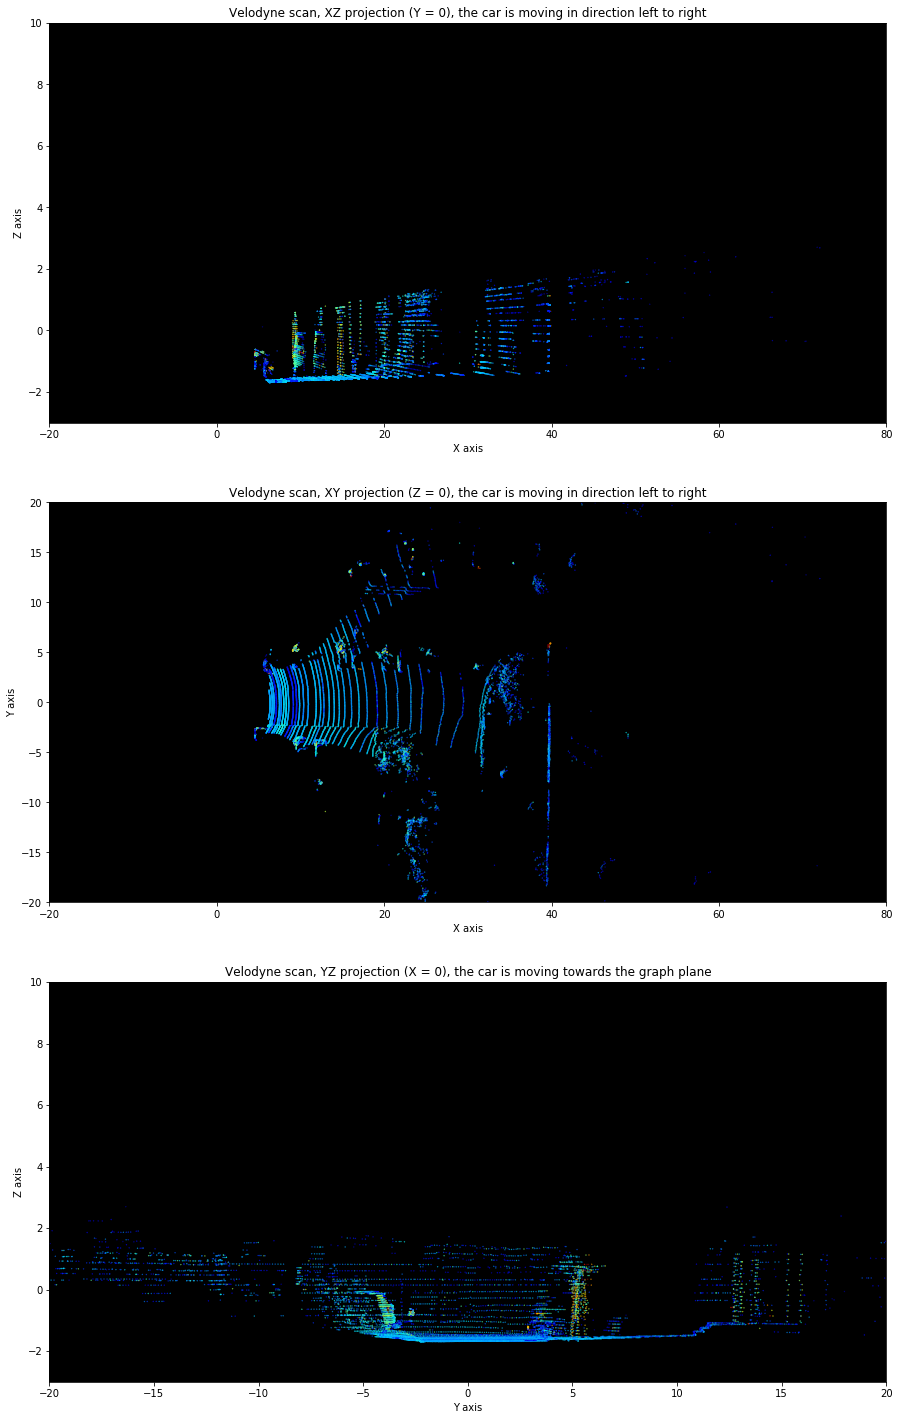

In [5]:
raw_lidar = np.fromfile(f_lidar[1],dtype=np.float32).reshape((-1,4))
camera = cv2.imread(f_rgb[1])
camera = cv2.cvtColor(camera, cv2.COLOR_BGR2RGB)
labels= [line for line in open(f_labels[1],'r').readlines()]
display_frame_statistics(raw_lidar,camera,labels,points=1.0)


## Object Detection Models

# VoxelNet 


### Front View

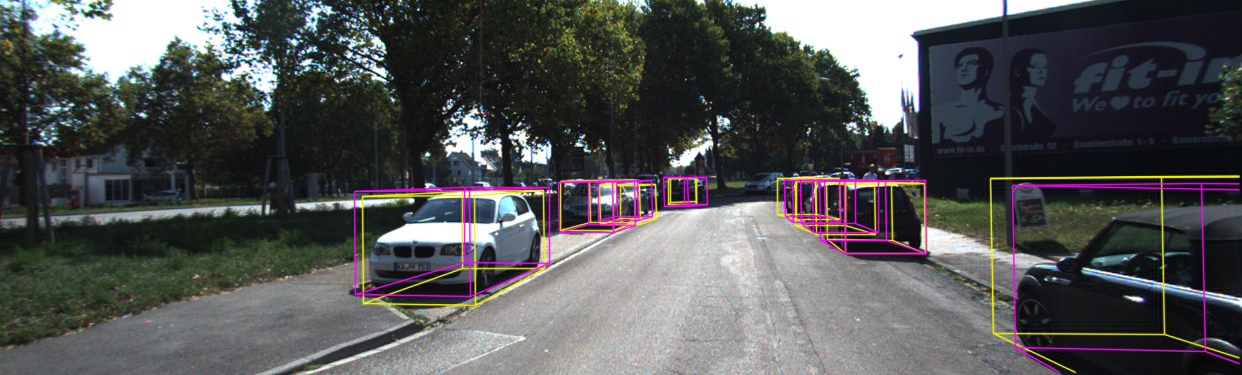

In [81]:
image = Im.open('/mnt/storage/home/ja17618/scratch/voxelnet/default_urban/vis/000010_front.jpg')
sub = image.convert("RGBA")
data = np.array(sub) 
red, green, blue, alpha = data.T 
data = np.array([blue, green, red, alpha])
data = data.transpose()
sub = Im.fromarray(data)
sub

### Birds Eye View

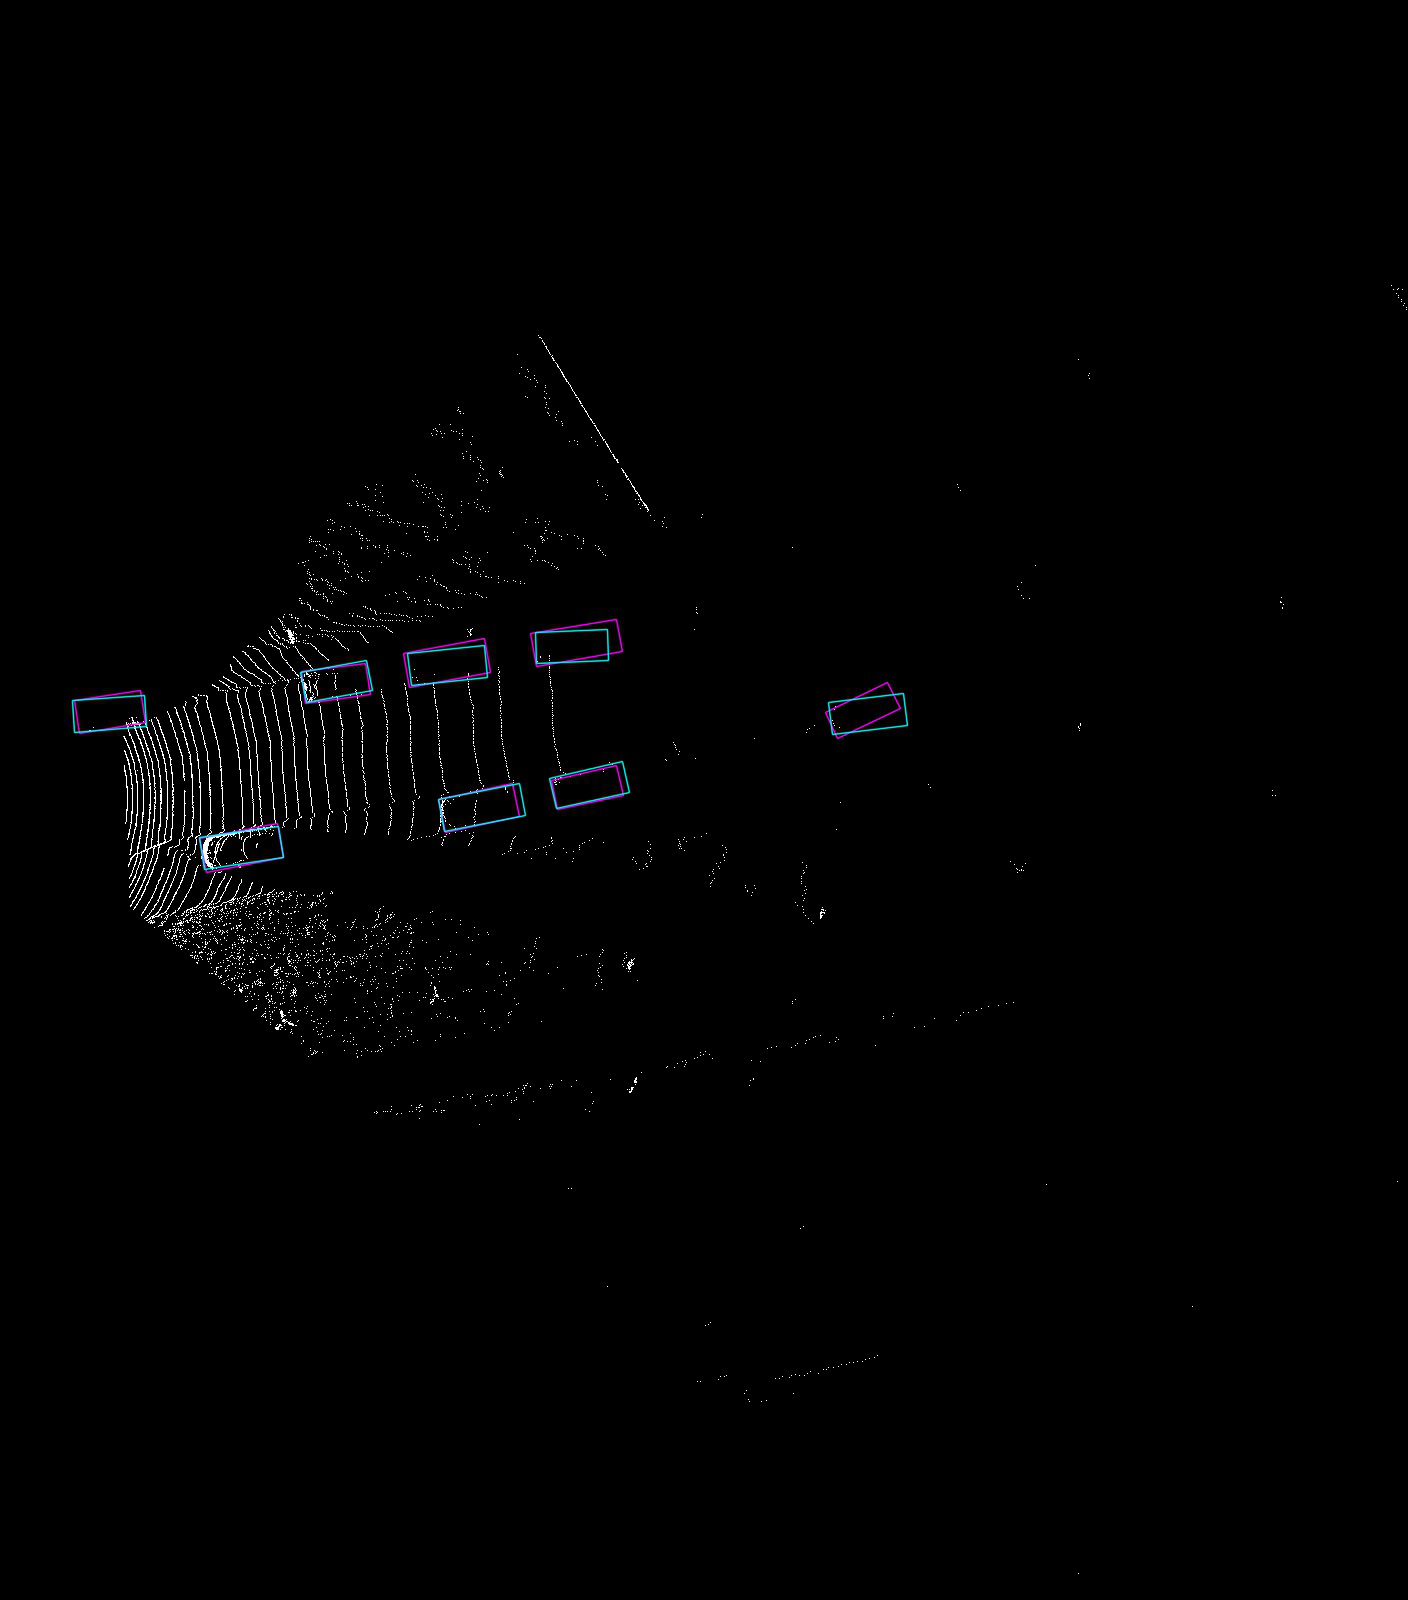

In [82]:
Im.open('/mnt/storage/home/ja17618/scratch/voxelnet/default_urban/vis/000010_bv.jpg')


## Aggregated View of Detection (AVOD)

In [104]:
! ls /mnt/storage/home/ja17618/scratch/avod/avod/data/outputs/avod_cars_example/predictions/images_2d/predictions/urban/105000/0.1

001338.png  002144.png	003516.png  003823.png	005627.png  007129.png
001981.png  002834.png	003760.png  004882.png	005684.png  007189.png
002024.png  003018.png	003815.png  005043.png	006932.png


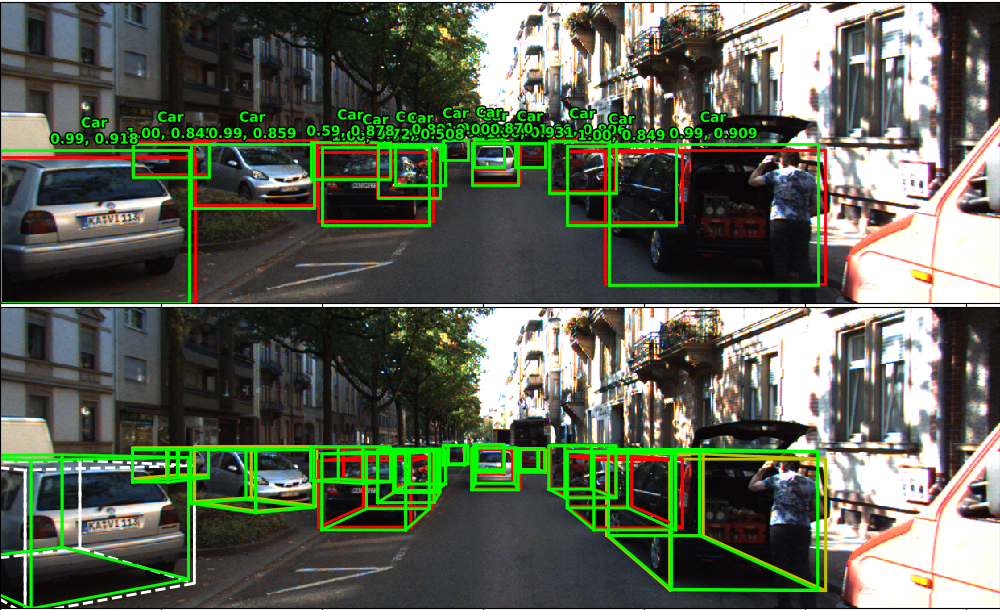

In [108]:
Image('/mnt/storage/home/ja17618/scratch/avod/avod/data/outputs/avod_cars_example/predictions/images_2d/predictions/urban/105000/0.1/006932.png')

## GPU Metrics for AVOD+VoxelNet Running Concurrently on a single NVIDIA P100 GP

## Are both Models capable of running concurrently?

In [28]:
def res(obj):
    non_decimal = re.compile(r'[^\d.]+')
    return float(non_decimal.sub('', obj))
def df_preprocess(df):
    df[' power.draw [W]'] = df[' power.draw [W]'].apply(lambda x: res(x))
    df[' utilization.gpu [%]'] = df[' utilization.gpu [%]'].apply(lambda x : res(x))
    df[' clocks.current.sm [MHz]'] = df[' clocks.current.sm [MHz]'].apply(lambda x : res(x))
    df[' memory.used [MiB]'] = df[' memory.used [MiB]'].apply(lambda x : res(x))
    t0 = df[' timestamp'][0]
    tm = df[' timestamp']
    t = [int((x-t0).total_seconds()) for x in tm]
    df = df.assign(timestep = t) 
    return df 
vox_urban = pd.read_csv('/mnt/storage/home/ja17618/voxtesturban.out',skiprows=0,dtype={' timestamp':str},parse_dates=[' timestamp'],date_parser=pd.to_datetime)
joint_vox_urban = df_preprocess(vox_urban)
print(joint_vox_urban.shape)
vox_nurban = pd.read_csv('/mnt/storage/home/ja17618/voxtestnon_urban.out',skiprows=0,dtype={' timestamp':str},parse_dates=[' timestamp'],date_parser=pd.to_datetime)
joint_vox_nurban = df_preprocess(vox_nurban)
print(joint_vox_nurban.shape)

avod_urban = pd.read_csv('/mnt/storage/home/ja17618/avodurban.out',skiprows=0,dtype={' timestamp':str},parse_dates=[' timestamp'],date_parser=pd.to_datetime)
joint_avod_urban = df_preprocess(avod_urban)
print(joint_avod_urban.shape)

avod_nurban = pd.read_csv('/mnt/storage/home/ja17618/avodnon_urban.out',skiprows=0,dtype={' timestamp':str},parse_dates=[' timestamp'],date_parser=pd.to_datetime)
joint_avod_nurban = df_preprocess(avod_nurban)
print(joint_avod_nurban.shape)


(546, 8)
(475, 8)
(678, 8)
(599, 8)


In [29]:

joint_urban = pd.concat((joint_avod_urban.drop(' timestamp',axis=1), joint_vox_urban.drop(' timestamp',axis=1)))
joint_urban = joint_urban.groupby(joint_urban.index).mean()
joint_nurban = pd.concat((joint_avod_nurban.drop(' timestamp',axis=1), joint_vox_nurban.drop(' timestamp',axis=1)))
joint_nurban = joint_nurban.groupby(joint_nurban.index).mean()


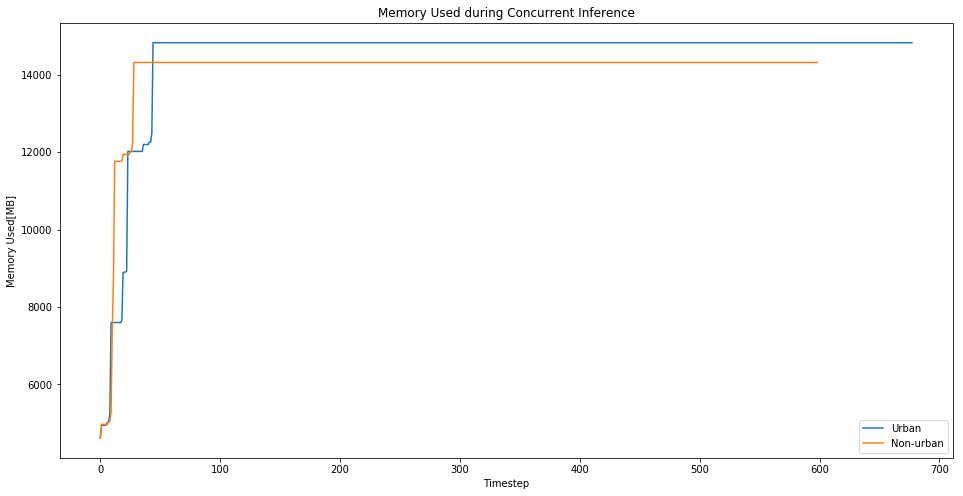

In [32]:
plt.figure(3,figsize=(16,8))
joint_urban[' memory.used [MiB]'].plot(label='Urban')
joint_nurban[' memory.used [MiB]'].plot(label='Non-urban')
plt.ylabel('Memory Used[MB]')
plt.xlabel('Timestep')
plt.title("Memory Used during Concurrent Inference")
plt.legend()

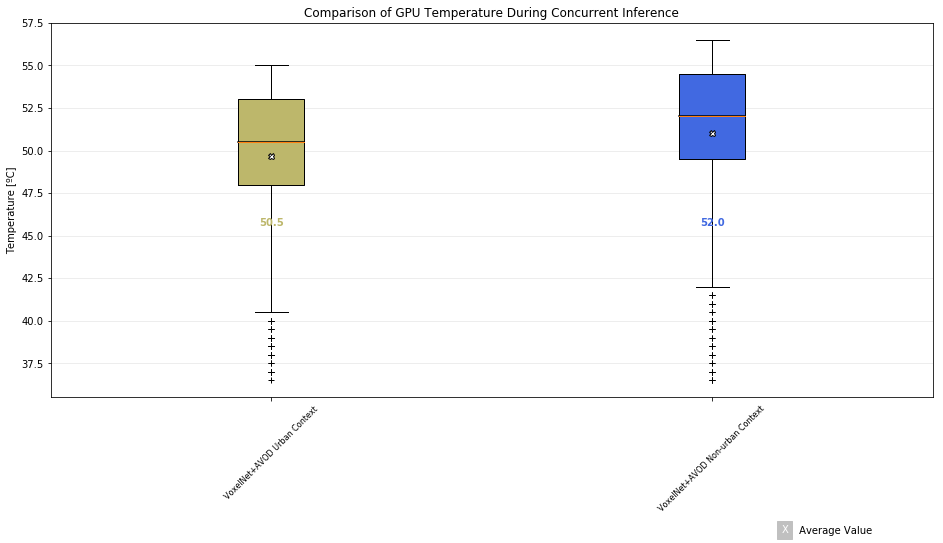

In [46]:
data = [joint_urban[' temperature.gpu'],joint_nurban[' temperature.gpu']]
dists = ['VoxelNet+AVOD Urban Context', 'VoxelNet+AVOD Non-urban Context']
fig, ax1 = plt.subplots(figsize=(14, 8))
fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
numDists = 1
bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparison of GPU Temperature During Concurrent Inference')
ax1.set_ylabel('Temperature [ºC]')

# Now fill the boxes with desired colors
boxColors = ['darkkhaki', 'royalblue']
numBoxes = numDists*2
medians = list(range(numBoxes))
for i in range(numBoxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
             color='w', marker='X', markeredgecolor='k')

# Set the axes ranges and axes labels
ax1.set_xlim(0.5, numBoxes + 0.5)
xtickNames = plt.setp(ax1, xticklabels=dists)
plt.setp(xtickNames, rotation=45, fontsize=8)

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)
pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
top=48
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', 
             size='medium', weight=weights[k],
             color=boxColors[k])


# Finally, add a basic legend
# plt.figtext(0.80, 0.08, str(N) + ' Random Numbers',
#             backgroundcolor=boxColors[0], color='black', weight='roman',
#             size='x-small')

plt.figtext(0.80, 0.015, 'X', color='white', backgroundcolor='silver',
            weight='roman', size='medium')
plt.figtext(0.815, 0.013, ' Average Value', color='black', weight='roman',
            size='medium')
# plt.savefig('gputempbox.png',dpi=300)
plt.show()

Text(0.5,1,'Concurrent Energy Comparison')

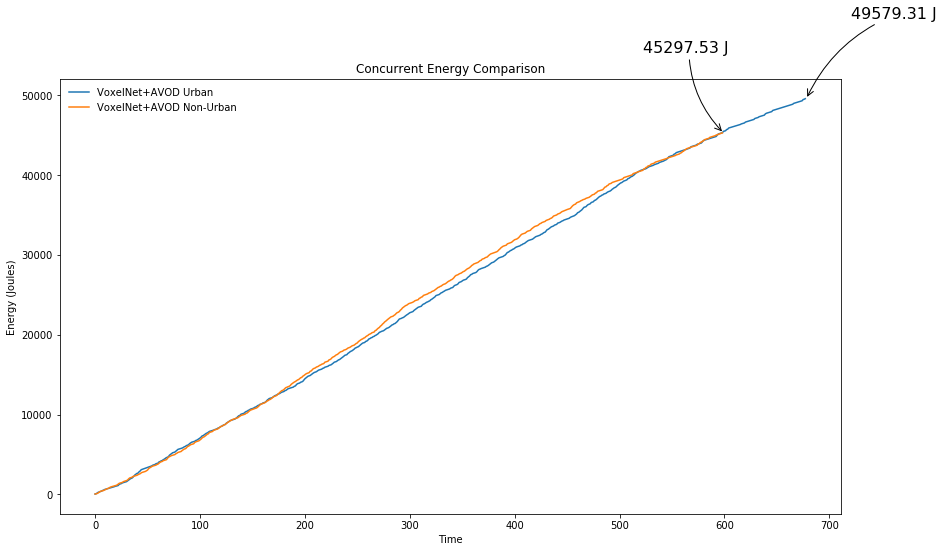

In [119]:
plt.figure(2,figsize=(14,8))
vu = joint_urban[' power.draw [W]'].cumsum()
a = vu.shape[0]
am = "{0:.2f}".format(vu.max())
aml = vu.max()


vnu = joint_nurban[' power.draw [W]'].cumsum()
b = vnu.shape[0]
aml = vu.max()
bm = "{0:.2f}".format(vnu.max())
bml = vnu.max()

plt.plot(vu,label='VoxelNet+AVOD Urban')
plt.annotate(f'{am} J ',#({int(float(am)/a)} Watts)',
             xy=(a, aml), xycoords='data',
             xytext=(+45, +80), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.plot(vnu,label='VoxelNet+AVOD Non-Urban')
plt.annotate(f'{bm} J ',# ({int(float(bm)/b)} Watts)',
             xy=(b, bml), xycoords='data',
             xytext=(-80, +80), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))


plt.legend(loc='upper left', frameon=False)
plt.ylabel('Energy (Joules)')
plt.xlabel('Time')
plt.title("Concurrent Energy Comparison")
# plt.savefig('energycomp.png',dpi=300)

## Answer: YES 

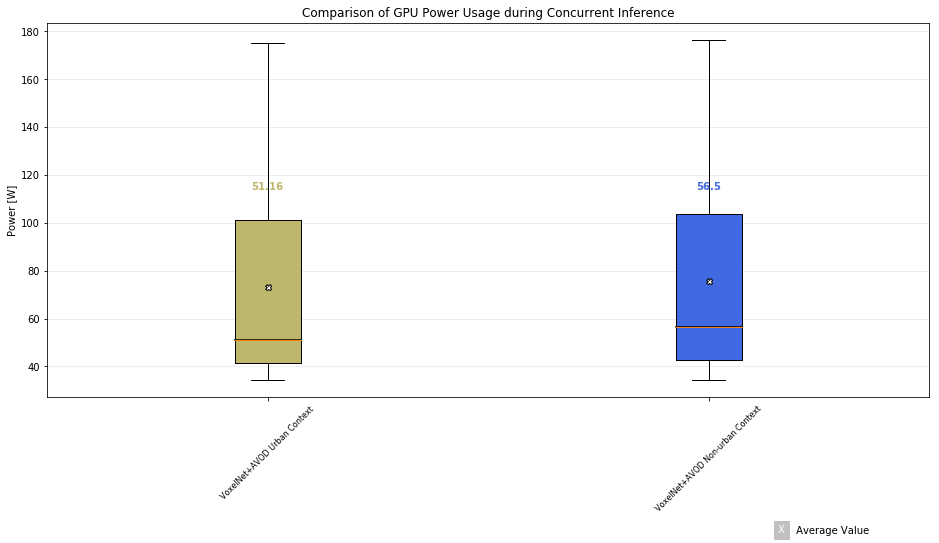

In [115]:
data = [joint_urban[' power.draw [W]'],joint_nurban[' power.draw [W]']]
dists = ['VoxelNet+AVOD Urban Context', 'VoxelNet+AVOD Non-urban Context']
fig, ax1 = plt.subplots(figsize=(14, 8))
fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
numDists = 1
bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparison of GPU Power Usage during Concurrent Inference')
ax1.set_ylabel('Power [W]')

# Now fill the boxes with desired colors
boxColors = ['darkkhaki', 'royalblue']
numBoxes = numDists*2
medians = list(range(numBoxes))
for i in range(numBoxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
             color='w', marker='X', markeredgecolor='k')

# Set the axes ranges and axes labels
ax1.set_xlim(0.5, numBoxes + 0.5)
xtickNames = plt.setp(ax1, xticklabels=dists)
plt.setp(xtickNames, rotation=45, fontsize=8)

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)
pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
top=120
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', 
             size='medium', weight=weights[k],
             color=boxColors[k])


# Finally, add a basic legend
# plt.figtext(0.80, 0.08, str(N) + ' Random Numbers',
#             backgroundcolor=boxColors[0], color='black', weight='roman',
#             size='x-small')

plt.figtext(0.80, 0.015, 'X', color='white', backgroundcolor='silver',
            weight='roman', size='medium')
plt.figtext(0.815, 0.013, ' Average Value', color='black', weight='roman',
            size='medium')
# plt.savefig('gputempbox.png',dpi=300)
plt.show()